# Initialization

## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
    
import torchvision.transforms.functional as tF

from models.unet import UNET
from models.resunet18 import RESUNET18

from dataset.dataset import seg_datasets

from utils.dataloader_utils import get_loader
from utils.save_load_utils import save_model, load_model
from utils.evaluation_utils import calculate_miou, check_acc
from utils.visualization_utils import save_pred_masks, visualize_segmentation, plot_segmentation
                                                                     
import albumentations as A

from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
import os
import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = False

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


## Hyperparameters

In [2]:
hyperparameters = {
    'test_dir' : './images/test',
    'train_dir' : './images/train',
    'seed' : 9999,
    'dataloader' :{
        'batch_size' : 8,
        'num_workers' : 4,
        'pin_memory' : False, 
    },
    'optimizer' :{
        'lr' : 1e-4,
        'betas' : (0.9, 0.999),
        'weight_decay' : 1e-4,
    },
    'epochs' : 150,
    'training_size' : 0,
    'test_size': 0,
    'gradient_clipping' : 1.0,
    'resunet': {
        'in_channels': 3,
        'out_channels': 1,
        'features': 64,
        'height': 320,
        'width': 320,
        'pre_trained_path': 'checkpoints/pretrained/pretrained_best.pth.tar'
    }, 
    'output_dir':{
        'results':'../generated_examples/resunet18/',
        'model1':'../generated_examples/resunet18/wc/',
        'model2':'../generated_examples/resunet18/kd/',
    },
    'checkpoints_dir':{
        'model1': './checkpoints/resunet18/wc/',
        'model2': './checkpoints/resunet18/kd/',
    },
}

## Seed Everything

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(hyperparameters['seed'])

# Data Preprocessing

## Data Augmentation

In [4]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

test_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

"""
test_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize(512, antialias=True)
])
"""
train_transforms, test_transforms

(Compose([
   HorizontalFlip(always_apply=False, p=0.5),
   VerticalFlip(always_apply=False, p=0.5),
   Rotate(always_apply=False, p=0.5, limit=(-90, 90), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
   Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
   Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True),
 Compose([
   Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
   Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True))

## Dataset

In [5]:
train_dataset = seg_datasets(hyperparameters['train_dir'], train_transforms)
test_dataset = seg_datasets(hyperparameters['test_dir'], test_transforms)

len(train_dataset), len(test_dataset)

(104, 27)

In [6]:
print(test_dataset.img_files)

['115_Plan.jpg', '119_Plan.jpg', '122_Plan.jpg', '125_Plan.jpg', '126_Plan.jpg', '131_Plan.jpg', '16_Plan.jpg', '17_Plan.jpg', '21_Plan.jpg', '26_Plan.jpg', '40_Plan.jpg', '41_Plan.jpg', '48_Plan.jpg', '4_Plan.jpg', '57_Plan.jpg', '58_Plan.jpg', '63_Plan.jpg', '66_Plan.jpg', '6_Plan.jpg', '73_Plan.jpg', '81_Plan.jpg', '88_Plan.jpg', '8_Plan.jpg', '92_Plan.jpg', '95_Plan.jpg', '98_Plan.jpg', '99_Plan.jpg']


In [7]:
hyperparameters['training_size'] = len(train_dataset)
hyperparameters['test_size'] = len(test_dataset)

In [8]:
sample = train_dataset[30]
torch.unique(sample[1])

tensor([0., 1., 2., 3.])

In [9]:
img, mask = train_dataset[20]
img.shape, mask.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


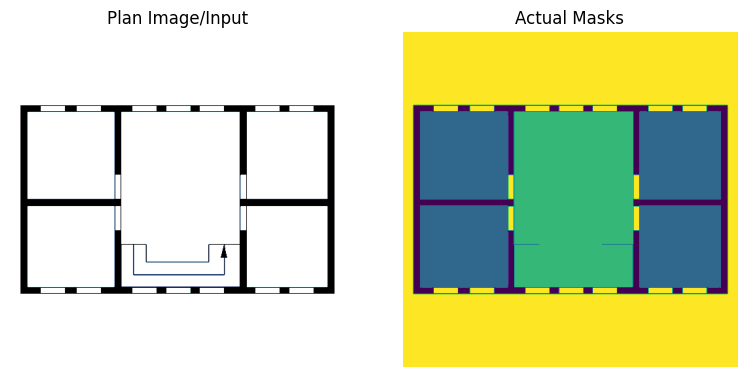

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout()
ax1.axis('off')
ax1.set_title('Plan Image/Input')
ax1.imshow(img.permute(1, 2, 0).numpy())
    
ax2.axis('off')
ax2.set_title('Actual Masks')
ax2.imshow(mask.numpy().transpose(1,2,0))

## Color Mapping

In [11]:
color_mapping = {
    0: (0, 0, 0),         # Walls
    1: (255, 80, 80),     # Iwan
    2: (80, 80, 255),     # Room
    3: (255, 255, 255),   # Background
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

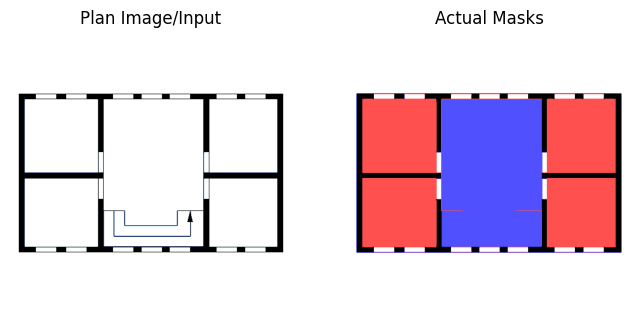

In [12]:
visualization = visualize_segmentation(mask, color_mapping, from_tensor=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.imshow(img.permute(1, 2, 0).numpy())
ax1.set_title('Plan Image/Input')
ax1.axis('off')

ax2.imshow(visualization)
ax2.set_title('Actual Masks')
ax2.axis('off')

## Dataloader

In [13]:
train_dataloader, test_dataloader = get_loader(
    train_dir = hyperparameters['train_dir'],
    test_dir = hyperparameters['test_dir'],
    batch_size = hyperparameters['dataloader']['batch_size'],
    train_transform = train_transforms,
    test_transform = test_transforms,
    num_workers = hyperparameters['dataloader']['num_workers'],
    pin_memory = hyperparameters['dataloader']['pin_memory']
)

len(train_dataloader), len(test_dataloader)

(13, 4)

In [14]:
img_a_batch, img_b_batch = next(iter(train_dataloader))
print(img_a_batch.shape, img_b_batch.shape)
print(img_a_batch.size(0))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])
8


# Model

## Model Loading

In [15]:
"""
model1 --> weight copy
model2 --> knowledge distillation

"""

model1 = RESUNET18(
    features=hyperparameters['resunet']['features'], 
    in_channels=hyperparameters['resunet']['in_channels'], 
    out_channels=hyperparameters['resunet']['out_channels']
)

model2 = RESUNET18(
    features=hyperparameters['resunet']['features'], 
    in_channels=hyperparameters['resunet']['in_channels'], 
    out_channels=hyperparameters['resunet']['out_channels']
)

## Pre-Trained Model Loading

In [16]:
!pip install pretrained-backbones-unet

In [17]:
from backbones_unet.model.unet import Unet

"""
pre_model:
    - weight source for model 1
    - teacher model for model 2
    - weight source and teacher model for model 3
"""

pre_model = Unet(
    backbone='convnext_base', # backbone network name
    in_channels=3,            # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=1,            # output channels (number of classes in your dataset)
)

checkpoint = torch.load(hyperparameters['resunet']['pre_trained_path'])
pre_model.load_state_dict(checkpoint['model_state_dict'], strict=True)

pre_model.to(device)

C:\Users\user\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unet(
  (encoder): FeatureListNet(
    (stem_0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (stem_1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_af

## Weight Copy

In [18]:
pretrained_dict = pre_model.state_dict()
model1_dict = model1.state_dict()

new_state_dict1 = {}

for k, v in pretrained_dict.items():
    if k in model1_dict:
        new_state_dict1[k] = v

model1_dict.update(new_state_dict1)
model1.load_state_dict(model1_dict)

<All keys matched successfully>

## Number of Parameters

In [19]:
### Dummy Data
__batch_size = 1
__in_channels = hyperparameters['resunet']['in_channels']
__width = hyperparameters['resunet']['width']
__height = hyperparameters['resunet']['height']

dummy_input = torch.randn((__batch_size, __in_channels, __height, __width))
dummy_out = model1(dummy_input)

print(f'Model input size: {dummy_input.shape}')
print(f'Model output size: {dummy_out.shape}')

Model input size: torch.Size([1, 3, 320, 320])
Model output size: torch.Size([1, 1, 320, 320])


In [20]:
print(f'Number of Parameters: {sum(dummy_out.numel() for p in model1.parameters()):,}')

Number of Parameters: 7,475,200


# Loss & Optimizer

## Loss Function

In [21]:
"""
model1 --> loss_fn (segmentation loss)
model2 --> total_loss (segmentation loss + distillation loss)

"""

'\nmodel1 --> loss_fn (segmentation loss)\nmodel2 --> total_loss (segmentation loss + distillation loss)\n\n'

In [22]:
criterion = nn.MSELoss(reduction='none')

def loss_fn(img_input, pred_student, mask, teacher_model, alpha=0.01):
    
    loss_by_pixel = criterion(pred_student, mask)
    loss = loss_by_pixel.mean()
    
    return loss

In [23]:
@torch.no_grad()
def dist_loss(img_input, pred_student, teacher_model):
    teacher_model.eval()
    pred_teacher = teacher_model(img_input)
    distill_loss_by_pixel = criterion(pred_student, pred_teacher)
    loss = distill_loss_by_pixel.mean()
    
    return loss

In [24]:
def total_loss(img_input, pred_student, mask, teacher_model, alpha=0.01):
    segmentation_loss = loss_fn(img_input, pred_student, mask, teacher_model)
    distillation_loss = dist_loss(img_input, pred_student, teacher_model)
    total_loss = segmentation_loss + alpha * distillation_loss
    
    return total_loss

## Optimizer & Scheduler

In [25]:
learning_rate = hyperparameters['optimizer']['lr']
betas = hyperparameters['optimizer']['betas']

optimizer1 = torch.optim.Adam(
    model1.parameters(),
    lr = learning_rate,
    betas = betas, 
)

optimizer2 = torch.optim.Adam(
    model2.parameters(),
    lr = learning_rate,
    betas = betas, 
)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', patience=20, factor=0.1)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', patience=20, factor=0.1)

In [26]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer1.state_dict():
    print(var_name, "\t", optimizer1.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]}]


# Training

## Train Function

In [27]:
def train_fn(
    epoch,
    model,
    dataloader, 
    optimizer, 
    scheduler,
    criterion, 
    device,
    gradient_clipping,
    summary_writer
):
    
    model.train()
    
    compute_avg = lambda x: sum(x) / len(x)
    total_batches = len(dataloader)
    write_interval = total_batches // 4
    
    avg_loss = []
    epochs = hyperparameters['epochs']
    
    with tqdm(total=hyperparameters['training_size'], desc=f'Train/Epoch {epoch}/{epochs}', unit='img') as pbar:
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()

            pred_mask = model(img)

            loss = criterion(img_input=img, 
                              pred_student=pred_mask, 
                              mask=mask, 
                              teacher_model=pre_model)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            optimizer.step()

            # Record Results
            avg_loss.append(loss.item())

            """
            # Update Progress Bar
            _avg_loss = compute_avg(avg_loss)
            
            if idx % write_interval == 0:
                summary_writer.add_scalar('Eval/Average Loss', _avg_loss, ((epoch-1)*total_batches) + idx)
            """
            
            pbar.update(img.shape[0])
        
    return compute_avg(avg_loss) 

## Evaluation Function

In [28]:
@torch.no_grad()
def eval_fn(
    epoch,
    model, 
    dataloader, 
    criterion, 
    device,
    color_mapping,
    summary_writer
):
    model.eval()
    
    # Average Loss and mIoU
    avg_loss = []
    avg_mIoU = []
    
    #Accuracy
    total_correct = 0
    total_pixel = 0

    compute_avg = lambda x: sum(x) / len(x)
    total_batches = len(dataloader)
    write_interval = total_batches // 4
    
    epochs = hyperparameters['epochs']
    
    with tqdm(total=hyperparameters['test_size'], desc=f'Eval/Epoch {epoch}/{epochs}', unit='img') as pbar:
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)

            #Accuracy
            num_correct, num_pixel = check_acc(img, mask, model, device)
            total_correct += num_correct
            total_pixel += num_pixel

            pred_mask = model(img)
            
            loss = criterion(img_input=img, 
                              pred_student=pred_mask, 
                              mask=mask, 
                              teacher_model=pre_model)

            # mIoU
            miou = calculate_miou(pred_mask, mask, color_mapping)

            avg_loss.append(loss.item())
            avg_mIoU.append(miou.item())
            
            
            """
            # Update Progress Bar
            _avg_loss = compute_avg(avg_loss)
            _avg_miou = compute_avg(avg_mIoU)
            
            if idx % write_interval == 0:
                summary_writer.add_scalar('Eval/Average Loss', _avg_loss, ((epoch-1)*total_batches) + idx)
                summary_writer.add_scalar('Eval/Average mIoU', _avg_miou, ((epoch-1)*total_batches) + idx)
            """  
            
            pbar.update(img.shape[0])

    acc = 100*(num_correct/num_pixel)
    return compute_avg(avg_loss), compute_avg(avg_mIoU), acc

## Start Training

In [29]:
best_model1 = {
    'best_state_dict' : None,
    'best_epoch' : None,
    'best_eval_loss' : None,
    'best_eval_miou' : 0.0,
    'best_eval_acc' : None,
}

best_model2 = {
    'best_state_dict' : None,
    'best_epoch' : None,
    'best_eval_loss' : None,
    'best_eval_miou' : 0.0,
    'best_eval_acc' : None,
}

history = {
    'model1':{
        'train_loss': [],
        'eval_loss' : [],
        'eval_miou' : [],
        'eval_acc' : [],
    },
    'model2':{
        'train_loss': [],
        'eval_loss' : [],
        'eval_miou' : [],
        'eval_acc' : [],
    },
}

In [30]:
def model1_train_start():
    model1.to(device)
    writer = SummaryWriter('runs/resunet18_model1')
    
    for epoch in range(1, hyperparameters['epochs']+1):  
        
        train_loss = train_fn(
            epoch = epoch,
            model = model1,
            dataloader = train_dataloader, 
            optimizer = optimizer1, 
            scheduler = scheduler1,
            criterion = loss_fn, 
            device = device,
            gradient_clipping = hyperparameters['gradient_clipping'],
            summary_writer = writer,
        )
        
        eval_loss, eval_miou, eval_acc = eval_fn(
            epoch = epoch,
            model = model1, 
            dataloader = test_dataloader, 
            criterion = loss_fn, 
            device = device,
            color_mapping = color_mapping,
            summary_writer = writer,
        )

        print(f""""
        Epoch: {epoch}, 
        Average Train Loss: {train_loss:.4f} |
        Average Test Loss: {eval_loss:.4f} |
        Average Test mIoU: {eval_miou:.2f}
        Average Test Accuracy: {eval_acc}""")
        
        
        #Tensorboard summary writer, saving the epoch results
        writer.add_scalar('Train Loss',train_loss, epoch)
        writer.add_scalar('Eval Loss',eval_loss, epoch)
        writer.add_scalar('Eval mIoU',eval_miou, epoch)
        writer.add_scalar('Eval Accuracy',eval_acc, epoch)
        
        
        history['model1']['train_loss'].append(train_loss)
        history['model1']['eval_loss'].append(eval_loss)
        history['model1']['eval_miou'].append(eval_miou)
        history['model1']['eval_acc'].append(eval_acc)
        
        
        save_model(
            model=model1, 
            optimizer=optimizer1, 
            root_folder=hyperparameters['checkpoints_dir']['model1'], 
            file_name='ResUNet18_Segmentation_checkpoint', 
            hyperparameter_dict=hyperparameters, 
            best_model=best_model1, 
            last_epoch=epoch, 
            verbose=False)
        
        if eval_miou > best_model1['best_eval_miou']:
            best_model1['best_state_dict'] = model1.state_dict().copy()
            best_model1['best_epoch'] = epoch
            best_model1['best_eval_loss'] = eval_loss
            best_model1['best_eval_miou'] = eval_miou
            best_model1['best_eval_acc'] = eval_acc
            
            save_model(
                model=model1, 
                optimizer=optimizer1, 
                root_folder=hyperparameters['checkpoints_dir']['model1'], 
                file_name='ResUNet18_Segmentation_best', 
                hyperparameter_dict=hyperparameters, 
                best_model=best_model1, 
                last_epoch=epoch, 
                verbose=True)
            
        scheduler1.step(eval_loss)
        
    writer.close()

In [31]:
def model2_train_start():
    model2.to(device)
    writer = SummaryWriter('runs/resunet18_model2')
    
    for epoch in range(1, hyperparameters['epochs']+1):  
        
        train_loss = train_fn(
            epoch = epoch,
            model = model2,
            dataloader = train_dataloader, 
            optimizer = optimizer2, 
            scheduler = scheduler2,
            criterion = total_loss, 
            device = device,
            gradient_clipping = hyperparameters['gradient_clipping'],
            summary_writer = writer,
        )
        
        eval_loss, eval_miou, eval_acc = eval_fn(
            epoch = epoch,
            model = model2, 
            dataloader = test_dataloader, 
            criterion = total_loss, 
            device = device,
            color_mapping = color_mapping,
            summary_writer = writer,
        )

        print(f""""
        Epoch: {epoch}, 
        Average Train Loss: {train_loss:.4f} |
        Average Test Loss: {eval_loss:.4f} |
        Average Test mIoU: {eval_miou:.2f}
        Average Test Accuracy: {eval_acc}""")
        
        
        #Tensorboard summary writer, saving the epoch results
        writer.add_scalar('Train Loss',train_loss, epoch)
        writer.add_scalar('Eval Loss',eval_loss, epoch)
        writer.add_scalar('Eval mIoU',eval_miou, epoch)
        writer.add_scalar('Eval Accuracy',eval_acc, epoch)
        
        
        history['model2']['train_loss'].append(train_loss)
        history['model2']['eval_loss'].append(eval_loss)
        history['model2']['eval_miou'].append(eval_miou)
        history['model2']['eval_acc'].append(eval_acc)
        
        save_model(
            model=model2, 
            optimizer=optimizer2, 
            root_folder=hyperparameters['checkpoints_dir']['model2'], 
            file_name='ResUNet18_Segmentation_checkpoint', 
            hyperparameter_dict=hyperparameters, 
            best_model=best_model2, 
            last_epoch=epoch, 
            verbose=False)
        
        if eval_miou > best_model2['best_eval_miou']:
            best_model2['best_state_dict'] = model2.state_dict().copy()
            best_model2['best_epoch'] = epoch
            best_model2['best_eval_loss'] = eval_loss
            best_model2['best_eval_miou'] = eval_miou
            best_model2['best_eval_acc'] = eval_acc
            
            save_model(
                model=model2, 
                optimizer=optimizer2, 
                root_folder=hyperparameters['checkpoints_dir']['model2'], 
                file_name='ResUNet18_Segmentation_best', 
                hyperparameter_dict=hyperparameters, 
                best_model=best_model2, 
                last_epoch=epoch, 
                verbose=True)
            
        scheduler2.step(eval_loss)
        
    writer.close()

## Model1 (Weight Copy) Training

In [32]:
model1_train_start()

Eval/Epoch 1/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 1, 
        Average Train Loss: 3.7209 |
        Average Test Loss: 4.1874 |
        Average Test mIoU: 1.54
        Average Test Accuracy: 6.26233434677124
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 2/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 2, 
        Average Train Loss: 2.1773 |
        Average Test Loss: 2.6776 |
        Average Test mIoU: 19.56
        Average Test Accuracy: 38.148372650146484
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 3/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.98img/s]


"
        Epoch: 3, 
        Average Train Loss: 0.8907 |
        Average Test Loss: 0.7990 |
        Average Test mIoU: 23.41
        Average Test Accuracy: 26.767730712890625
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 4/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.94img/s]


"
        Epoch: 4, 
        Average Train Loss: 0.4720 |
        Average Test Loss: 1.2100 |
        Average Test mIoU: 36.84
        Average Test Accuracy: 44.62687301635742
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 5/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 5, 
        Average Train Loss: 0.3813 |
        Average Test Loss: 0.5030 |
        Average Test mIoU: 42.94
        Average Test Accuracy: 45.55524444580078
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 6/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.74img/s]


"
        Epoch: 6, 
        Average Train Loss: 0.3419 |
        Average Test Loss: 0.2723 |
        Average Test mIoU: 58.30
        Average Test Accuracy: 67.06632232666016
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 7/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.76img/s]


"
        Epoch: 7, 
        Average Train Loss: 0.3158 |
        Average Test Loss: 0.4120 |
        Average Test mIoU: 49.47
        Average Test Accuracy: 64.23530578613281


Eval/Epoch 8/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 8, 
        Average Train Loss: 0.2579 |
        Average Test Loss: 0.3330 |
        Average Test mIoU: 57.63
        Average Test Accuracy: 66.88906860351562


Eval/Epoch 9/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.01img/s]


"
        Epoch: 9, 
        Average Train Loss: 0.2481 |
        Average Test Loss: 0.3636 |
        Average Test mIoU: 57.60
        Average Test Accuracy: 77.67283630371094


Eval/Epoch 10/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.82img/s]


"
        Epoch: 10, 
        Average Train Loss: 0.2635 |
        Average Test Loss: 0.2018 |
        Average Test mIoU: 64.24
        Average Test Accuracy: 76.94982147216797
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 11/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.01img/s]


"
        Epoch: 11, 
        Average Train Loss: 0.2343 |
        Average Test Loss: 0.1927 |
        Average Test mIoU: 70.69
        Average Test Accuracy: 85.11962890625
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 12/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.02img/s]


"
        Epoch: 12, 
        Average Train Loss: 0.2151 |
        Average Test Loss: 0.1978 |
        Average Test mIoU: 68.39
        Average Test Accuracy: 80.70449829101562


Eval/Epoch 13/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.97img/s]


"
        Epoch: 13, 
        Average Train Loss: 0.2055 |
        Average Test Loss: 0.1913 |
        Average Test mIoU: 69.55
        Average Test Accuracy: 85.67657470703125


Eval/Epoch 14/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.02img/s]


"
        Epoch: 14, 
        Average Train Loss: 0.2085 |
        Average Test Loss: 0.1952 |
        Average Test mIoU: 67.34
        Average Test Accuracy: 84.11891174316406


Eval/Epoch 15/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.97img/s]


"
        Epoch: 15, 
        Average Train Loss: 0.1719 |
        Average Test Loss: 0.1884 |
        Average Test mIoU: 68.93
        Average Test Accuracy: 81.58709716796875


Eval/Epoch 16/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 16, 
        Average Train Loss: 0.1827 |
        Average Test Loss: 0.1442 |
        Average Test mIoU: 74.31
        Average Test Accuracy: 89.89690399169922
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 17/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.01img/s]


"
        Epoch: 17, 
        Average Train Loss: 0.1654 |
        Average Test Loss: 0.1668 |
        Average Test mIoU: 72.38
        Average Test Accuracy: 87.73117065429688


Eval/Epoch 18/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.82img/s]


"
        Epoch: 18, 
        Average Train Loss: 0.1686 |
        Average Test Loss: 0.1365 |
        Average Test mIoU: 74.61
        Average Test Accuracy: 89.8381576538086
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 19/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 19, 
        Average Train Loss: 0.1512 |
        Average Test Loss: 0.1643 |
        Average Test mIoU: 71.01
        Average Test Accuracy: 87.09119415283203


Eval/Epoch 20/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 20, 
        Average Train Loss: 0.1582 |
        Average Test Loss: 0.1135 |
        Average Test mIoU: 79.87
        Average Test Accuracy: 93.13316345214844
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 21/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 21, 
        Average Train Loss: 0.1429 |
        Average Test Loss: 0.1572 |
        Average Test mIoU: 74.42
        Average Test Accuracy: 88.23356628417969


Eval/Epoch 22/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.98img/s]


"
        Epoch: 22, 
        Average Train Loss: 0.1419 |
        Average Test Loss: 0.1186 |
        Average Test mIoU: 77.77
        Average Test Accuracy: 91.60334777832031


Eval/Epoch 23/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.20img/s]


"
        Epoch: 23, 
        Average Train Loss: 0.1418 |
        Average Test Loss: 0.1380 |
        Average Test mIoU: 74.78
        Average Test Accuracy: 86.77253723144531


Eval/Epoch 24/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.06img/s]


"
        Epoch: 24, 
        Average Train Loss: 0.1507 |
        Average Test Loss: 0.1197 |
        Average Test mIoU: 77.11
        Average Test Accuracy: 90.66556549072266


Eval/Epoch 25/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.15img/s]


"
        Epoch: 25, 
        Average Train Loss: 0.1390 |
        Average Test Loss: 0.1114 |
        Average Test mIoU: 79.18
        Average Test Accuracy: 91.19033813476562


Eval/Epoch 26/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 26, 
        Average Train Loss: 0.1290 |
        Average Test Loss: 0.1118 |
        Average Test mIoU: 80.25
        Average Test Accuracy: 92.8532943725586
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 27/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 27, 
        Average Train Loss: 0.1245 |
        Average Test Loss: 0.1063 |
        Average Test mIoU: 81.22
        Average Test Accuracy: 93.34691619873047
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 28/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 28, 
        Average Train Loss: 0.1432 |
        Average Test Loss: 0.1178 |
        Average Test mIoU: 77.79
        Average Test Accuracy: 89.70655059814453


Eval/Epoch 29/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.89img/s]


"
        Epoch: 29, 
        Average Train Loss: 0.1268 |
        Average Test Loss: 0.1237 |
        Average Test mIoU: 77.76
        Average Test Accuracy: 89.34644317626953


Eval/Epoch 30/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.85img/s]


"
        Epoch: 30, 
        Average Train Loss: 0.1104 |
        Average Test Loss: 0.1063 |
        Average Test mIoU: 81.08
        Average Test Accuracy: 92.28643035888672


Eval/Epoch 31/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.01img/s]


"
        Epoch: 31, 
        Average Train Loss: 0.1319 |
        Average Test Loss: 0.1189 |
        Average Test mIoU: 77.14
        Average Test Accuracy: 90.487548828125


Eval/Epoch 32/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 32, 
        Average Train Loss: 0.1314 |
        Average Test Loss: 0.1151 |
        Average Test mIoU: 78.97
        Average Test Accuracy: 89.12010192871094


Eval/Epoch 33/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 33, 
        Average Train Loss: 0.1137 |
        Average Test Loss: 0.1069 |
        Average Test mIoU: 80.84
        Average Test Accuracy: 93.37565612792969


Eval/Epoch 34/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 34, 
        Average Train Loss: 0.1172 |
        Average Test Loss: 0.0927 |
        Average Test mIoU: 82.19
        Average Test Accuracy: 94.78912353515625
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 35/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 35, 
        Average Train Loss: 0.1104 |
        Average Test Loss: 0.1129 |
        Average Test mIoU: 79.87
        Average Test Accuracy: 92.59745788574219


Eval/Epoch 36/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 36, 
        Average Train Loss: 0.1144 |
        Average Test Loss: 0.0956 |
        Average Test mIoU: 82.07
        Average Test Accuracy: 93.8481674194336


Eval/Epoch 37/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 37, 
        Average Train Loss: 0.1216 |
        Average Test Loss: 0.0955 |
        Average Test mIoU: 81.51
        Average Test Accuracy: 93.15719604492188


Eval/Epoch 38/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 38, 
        Average Train Loss: 0.1187 |
        Average Test Loss: 0.0873 |
        Average Test mIoU: 84.07
        Average Test Accuracy: 95.44029235839844
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 39/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 39, 
        Average Train Loss: 0.1151 |
        Average Test Loss: 0.1046 |
        Average Test mIoU: 81.03
        Average Test Accuracy: 93.62590026855469


Eval/Epoch 40/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 40, 
        Average Train Loss: 0.1144 |
        Average Test Loss: 0.1081 |
        Average Test mIoU: 80.27
        Average Test Accuracy: 93.22306823730469


Eval/Epoch 41/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 41, 
        Average Train Loss: 0.1009 |
        Average Test Loss: 0.0828 |
        Average Test mIoU: 85.02
        Average Test Accuracy: 95.61614990234375
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 42/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 42, 
        Average Train Loss: 0.0960 |
        Average Test Loss: 0.0933 |
        Average Test mIoU: 82.78
        Average Test Accuracy: 92.88139343261719


Eval/Epoch 43/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 43, 
        Average Train Loss: 0.0982 |
        Average Test Loss: 0.0872 |
        Average Test mIoU: 83.43
        Average Test Accuracy: 94.3907470703125


Eval/Epoch 44/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 44, 
        Average Train Loss: 0.0955 |
        Average Test Loss: 0.0928 |
        Average Test mIoU: 82.45
        Average Test Accuracy: 91.68777465820312


Eval/Epoch 45/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 45, 
        Average Train Loss: 0.1033 |
        Average Test Loss: 0.0923 |
        Average Test mIoU: 82.21
        Average Test Accuracy: 94.84100341796875


Eval/Epoch 46/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 46, 
        Average Train Loss: 0.1109 |
        Average Test Loss: 0.1007 |
        Average Test mIoU: 81.54
        Average Test Accuracy: 93.01261901855469


Eval/Epoch 47/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 47, 
        Average Train Loss: 0.1035 |
        Average Test Loss: 0.0984 |
        Average Test mIoU: 82.81
        Average Test Accuracy: 93.40604400634766


Eval/Epoch 48/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 48, 
        Average Train Loss: 0.1037 |
        Average Test Loss: 0.1014 |
        Average Test mIoU: 81.97
        Average Test Accuracy: 93.84613037109375


Eval/Epoch 49/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 49, 
        Average Train Loss: 0.0902 |
        Average Test Loss: 0.0970 |
        Average Test mIoU: 81.38
        Average Test Accuracy: 92.55269622802734


Eval/Epoch 50/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 50, 
        Average Train Loss: 0.1005 |
        Average Test Loss: 0.0927 |
        Average Test mIoU: 83.64
        Average Test Accuracy: 95.66790771484375


Eval/Epoch 51/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 51, 
        Average Train Loss: 0.1024 |
        Average Test Loss: 0.0994 |
        Average Test mIoU: 82.44
        Average Test Accuracy: 93.44546508789062


Eval/Epoch 52/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 52, 
        Average Train Loss: 0.0993 |
        Average Test Loss: 0.1028 |
        Average Test mIoU: 82.67
        Average Test Accuracy: 94.09561157226562


Eval/Epoch 53/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 53, 
        Average Train Loss: 0.0962 |
        Average Test Loss: 0.0812 |
        Average Test mIoU: 84.52
        Average Test Accuracy: 94.81227111816406


Eval/Epoch 54/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 54, 
        Average Train Loss: 0.0945 |
        Average Test Loss: 0.0866 |
        Average Test mIoU: 84.49
        Average Test Accuracy: 94.77500915527344


Eval/Epoch 55/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 55, 
        Average Train Loss: 0.0876 |
        Average Test Loss: 0.0929 |
        Average Test mIoU: 82.85
        Average Test Accuracy: 94.72987365722656


Eval/Epoch 56/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 56, 
        Average Train Loss: 0.0874 |
        Average Test Loss: 0.0822 |
        Average Test mIoU: 84.32
        Average Test Accuracy: 94.47314453125


Eval/Epoch 57/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.31img/s]


"
        Epoch: 57, 
        Average Train Loss: 0.0851 |
        Average Test Loss: 0.1026 |
        Average Test mIoU: 83.08
        Average Test Accuracy: 94.78594970703125


Eval/Epoch 58/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 58, 
        Average Train Loss: 0.0795 |
        Average Test Loss: 0.0880 |
        Average Test mIoU: 84.58
        Average Test Accuracy: 94.83960723876953


Eval/Epoch 59/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 59, 
        Average Train Loss: 0.0843 |
        Average Test Loss: 0.0872 |
        Average Test mIoU: 83.84
        Average Test Accuracy: 93.81358337402344


Eval/Epoch 60/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.05img/s]


"
        Epoch: 60, 
        Average Train Loss: 0.0849 |
        Average Test Loss: 0.0921 |
        Average Test mIoU: 84.45
        Average Test Accuracy: 95.12303924560547


Eval/Epoch 61/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 61, 
        Average Train Loss: 0.0863 |
        Average Test Loss: 0.1033 |
        Average Test mIoU: 80.61
        Average Test Accuracy: 92.437744140625


Eval/Epoch 62/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 62, 
        Average Train Loss: 0.0948 |
        Average Test Loss: 0.0946 |
        Average Test mIoU: 82.56
        Average Test Accuracy: 93.50141143798828


Eval/Epoch 63/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 63, 
        Average Train Loss: 0.0796 |
        Average Test Loss: 0.0801 |
        Average Test mIoU: 85.73
        Average Test Accuracy: 96.11600494384766
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 64/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 64, 
        Average Train Loss: 0.0882 |
        Average Test Loss: 0.0753 |
        Average Test mIoU: 85.74
        Average Test Accuracy: 94.68498229980469
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 65/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 65, 
        Average Train Loss: 0.0930 |
        Average Test Loss: 0.0805 |
        Average Test mIoU: 84.95
        Average Test Accuracy: 95.62352752685547


Eval/Epoch 66/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 66, 
        Average Train Loss: 0.0857 |
        Average Test Loss: 0.0913 |
        Average Test mIoU: 84.29
        Average Test Accuracy: 95.33004760742188


Eval/Epoch 67/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 67, 
        Average Train Loss: 0.0912 |
        Average Test Loss: 0.0847 |
        Average Test mIoU: 85.35
        Average Test Accuracy: 95.85113525390625


Eval/Epoch 68/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 68, 
        Average Train Loss: 0.0868 |
        Average Test Loss: 0.0948 |
        Average Test mIoU: 83.28
        Average Test Accuracy: 93.6120376586914


Eval/Epoch 69/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 69, 
        Average Train Loss: 0.0800 |
        Average Test Loss: 0.0771 |
        Average Test mIoU: 84.55
        Average Test Accuracy: 95.0566635131836


Eval/Epoch 70/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 70, 
        Average Train Loss: 0.0805 |
        Average Test Loss: 0.0844 |
        Average Test mIoU: 84.81
        Average Test Accuracy: 94.23701477050781


Eval/Epoch 71/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 71, 
        Average Train Loss: 0.0779 |
        Average Test Loss: 0.0763 |
        Average Test mIoU: 86.57
        Average Test Accuracy: 96.3078842163086
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 72/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.08img/s]


"
        Epoch: 72, 
        Average Train Loss: 0.0743 |
        Average Test Loss: 0.0835 |
        Average Test mIoU: 85.92
        Average Test Accuracy: 96.13876342773438


Eval/Epoch 73/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 73, 
        Average Train Loss: 0.0798 |
        Average Test Loss: 0.0880 |
        Average Test mIoU: 85.45
        Average Test Accuracy: 95.38002014160156


Eval/Epoch 74/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.94img/s]


"
        Epoch: 74, 
        Average Train Loss: 0.0817 |
        Average Test Loss: 0.0831 |
        Average Test mIoU: 84.65
        Average Test Accuracy: 95.0810775756836


Eval/Epoch 75/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 75, 
        Average Train Loss: 0.0871 |
        Average Test Loss: 0.0985 |
        Average Test mIoU: 82.36
        Average Test Accuracy: 92.47869110107422


Eval/Epoch 76/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 76, 
        Average Train Loss: 0.0733 |
        Average Test Loss: 0.0776 |
        Average Test mIoU: 85.53
        Average Test Accuracy: 95.96685028076172


Eval/Epoch 77/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 77, 
        Average Train Loss: 0.0755 |
        Average Test Loss: 0.0862 |
        Average Test mIoU: 84.08
        Average Test Accuracy: 93.59054565429688


Eval/Epoch 78/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 78, 
        Average Train Loss: 0.0743 |
        Average Test Loss: 0.0833 |
        Average Test mIoU: 84.59
        Average Test Accuracy: 94.99969482421875


Eval/Epoch 79/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 79, 
        Average Train Loss: 0.0717 |
        Average Test Loss: 0.0842 |
        Average Test mIoU: 83.97
        Average Test Accuracy: 94.06840515136719


Eval/Epoch 80/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 80, 
        Average Train Loss: 0.0774 |
        Average Test Loss: 0.0781 |
        Average Test mIoU: 86.52
        Average Test Accuracy: 96.74034118652344


Eval/Epoch 81/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 81, 
        Average Train Loss: 0.0748 |
        Average Test Loss: 0.0916 |
        Average Test mIoU: 83.19
        Average Test Accuracy: 93.46784210205078


Eval/Epoch 82/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.85img/s]


"
        Epoch: 82, 
        Average Train Loss: 0.0744 |
        Average Test Loss: 0.0817 |
        Average Test mIoU: 85.61
        Average Test Accuracy: 95.7635269165039


Eval/Epoch 83/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 83, 
        Average Train Loss: 0.0749 |
        Average Test Loss: 0.0837 |
        Average Test mIoU: 85.85
        Average Test Accuracy: 95.60127258300781


Eval/Epoch 84/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 84, 
        Average Train Loss: 0.0822 |
        Average Test Loss: 0.0897 |
        Average Test mIoU: 84.54
        Average Test Accuracy: 93.91187286376953


Eval/Epoch 85/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 85, 
        Average Train Loss: 0.0740 |
        Average Test Loss: 0.0720 |
        Average Test mIoU: 86.82
        Average Test Accuracy: 96.8266830444336
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 86/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 86, 
        Average Train Loss: 0.0670 |
        Average Test Loss: 0.0834 |
        Average Test mIoU: 85.67
        Average Test Accuracy: 95.77674865722656


Eval/Epoch 87/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 87, 
        Average Train Loss: 0.0761 |
        Average Test Loss: 0.0931 |
        Average Test mIoU: 85.73
        Average Test Accuracy: 96.09400939941406


Eval/Epoch 88/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 88, 
        Average Train Loss: 0.0722 |
        Average Test Loss: 0.0728 |
        Average Test mIoU: 87.03
        Average Test Accuracy: 96.52430725097656
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 89/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.85img/s]


"
        Epoch: 89, 
        Average Train Loss: 0.0786 |
        Average Test Loss: 0.0812 |
        Average Test mIoU: 84.99
        Average Test Accuracy: 93.64217376708984


Eval/Epoch 90/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 90, 
        Average Train Loss: 0.0680 |
        Average Test Loss: 0.0748 |
        Average Test mIoU: 86.07
        Average Test Accuracy: 96.2188720703125


Eval/Epoch 91/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 91, 
        Average Train Loss: 0.0684 |
        Average Test Loss: 0.0752 |
        Average Test mIoU: 86.91
        Average Test Accuracy: 95.72181701660156


Eval/Epoch 92/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 92, 
        Average Train Loss: 0.0619 |
        Average Test Loss: 0.0799 |
        Average Test mIoU: 85.79
        Average Test Accuracy: 94.8968276977539


Eval/Epoch 93/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 93, 
        Average Train Loss: 0.0664 |
        Average Test Loss: 0.0924 |
        Average Test mIoU: 84.78
        Average Test Accuracy: 95.5571517944336


Eval/Epoch 94/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 94, 
        Average Train Loss: 0.0652 |
        Average Test Loss: 0.0827 |
        Average Test mIoU: 85.02
        Average Test Accuracy: 95.01546478271484


Eval/Epoch 95/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 95, 
        Average Train Loss: 0.0648 |
        Average Test Loss: 0.0976 |
        Average Test mIoU: 82.28
        Average Test Accuracy: 92.54252624511719


Eval/Epoch 96/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 96, 
        Average Train Loss: 0.0644 |
        Average Test Loss: 0.0828 |
        Average Test mIoU: 85.61
        Average Test Accuracy: 95.64031219482422


Eval/Epoch 97/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 97, 
        Average Train Loss: 0.0688 |
        Average Test Loss: 0.0744 |
        Average Test mIoU: 86.61
        Average Test Accuracy: 95.02334594726562


Eval/Epoch 98/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 98, 
        Average Train Loss: 0.0612 |
        Average Test Loss: 0.0866 |
        Average Test mIoU: 84.30
        Average Test Accuracy: 95.6419677734375


Eval/Epoch 99/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 99, 
        Average Train Loss: 0.0727 |
        Average Test Loss: 0.0833 |
        Average Test mIoU: 86.73
        Average Test Accuracy: 97.06141662597656


Eval/Epoch 100/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 100, 
        Average Train Loss: 0.0640 |
        Average Test Loss: 0.0879 |
        Average Test mIoU: 84.88
        Average Test Accuracy: 96.2767333984375


Eval/Epoch 101/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 101, 
        Average Train Loss: 0.0634 |
        Average Test Loss: 0.0724 |
        Average Test mIoU: 87.40
        Average Test Accuracy: 96.3933334350586
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 102/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 102, 
        Average Train Loss: 0.0604 |
        Average Test Loss: 0.0716 |
        Average Test mIoU: 87.53
        Average Test Accuracy: 96.92357635498047
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 103/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 103, 
        Average Train Loss: 0.0650 |
        Average Test Loss: 0.1085 |
        Average Test mIoU: 80.64
        Average Test Accuracy: 92.09735107421875


Eval/Epoch 104/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 104, 
        Average Train Loss: 0.0627 |
        Average Test Loss: 0.0724 |
        Average Test mIoU: 86.31
        Average Test Accuracy: 94.39163208007812


Eval/Epoch 105/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 105, 
        Average Train Loss: 0.0613 |
        Average Test Loss: 0.0790 |
        Average Test mIoU: 86.12
        Average Test Accuracy: 96.04644775390625


Eval/Epoch 106/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 106, 
        Average Train Loss: 0.0688 |
        Average Test Loss: 0.0859 |
        Average Test mIoU: 85.11
        Average Test Accuracy: 94.45597839355469


Eval/Epoch 107/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 107, 
        Average Train Loss: 0.0626 |
        Average Test Loss: 0.0693 |
        Average Test mIoU: 86.92
        Average Test Accuracy: 95.44741821289062


Eval/Epoch 108/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 108, 
        Average Train Loss: 0.0648 |
        Average Test Loss: 0.0749 |
        Average Test mIoU: 86.48
        Average Test Accuracy: 96.35480499267578


Eval/Epoch 109/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.85img/s]


"
        Epoch: 109, 
        Average Train Loss: 0.0601 |
        Average Test Loss: 0.0697 |
        Average Test mIoU: 87.73
        Average Test Accuracy: 97.08646392822266
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 110/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 110, 
        Average Train Loss: 0.0676 |
        Average Test Loss: 0.0714 |
        Average Test mIoU: 86.66
        Average Test Accuracy: 94.98303985595703


Eval/Epoch 111/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 111, 
        Average Train Loss: 0.0701 |
        Average Test Loss: 0.0747 |
        Average Test mIoU: 86.58
        Average Test Accuracy: 95.63331604003906


Eval/Epoch 112/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 112, 
        Average Train Loss: 0.0625 |
        Average Test Loss: 0.0691 |
        Average Test mIoU: 87.36
        Average Test Accuracy: 97.49819946289062


Eval/Epoch 113/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 113, 
        Average Train Loss: 0.0603 |
        Average Test Loss: 0.0624 |
        Average Test mIoU: 88.72
        Average Test Accuracy: 96.60975646972656
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 114/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 114, 
        Average Train Loss: 0.0608 |
        Average Test Loss: 0.0664 |
        Average Test mIoU: 87.98
        Average Test Accuracy: 96.61738586425781


Eval/Epoch 115/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 115, 
        Average Train Loss: 0.0632 |
        Average Test Loss: 0.0935 |
        Average Test mIoU: 82.58
        Average Test Accuracy: 93.575927734375


Eval/Epoch 116/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 116, 
        Average Train Loss: 0.0602 |
        Average Test Loss: 0.0723 |
        Average Test mIoU: 87.92
        Average Test Accuracy: 96.37044525146484


Eval/Epoch 117/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 117, 
        Average Train Loss: 0.0657 |
        Average Test Loss: 0.0836 |
        Average Test mIoU: 87.13
        Average Test Accuracy: 97.11138916015625


Eval/Epoch 118/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.59img/s]


"
        Epoch: 118, 
        Average Train Loss: 0.0599 |
        Average Test Loss: 0.0670 |
        Average Test mIoU: 87.92
        Average Test Accuracy: 96.1613998413086


Eval/Epoch 119/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 119, 
        Average Train Loss: 0.0689 |
        Average Test Loss: 0.0794 |
        Average Test mIoU: 85.85
        Average Test Accuracy: 95.75564575195312


Eval/Epoch 120/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 120, 
        Average Train Loss: 0.0542 |
        Average Test Loss: 0.0660 |
        Average Test mIoU: 88.73
        Average Test Accuracy: 96.6795654296875
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 121/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 121, 
        Average Train Loss: 0.0554 |
        Average Test Loss: 0.0664 |
        Average Test mIoU: 88.28
        Average Test Accuracy: 96.31526184082031


Eval/Epoch 122/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 122, 
        Average Train Loss: 0.0549 |
        Average Test Loss: 0.0705 |
        Average Test mIoU: 87.09
        Average Test Accuracy: 96.55303955078125


Eval/Epoch 123/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 123, 
        Average Train Loss: 0.0502 |
        Average Test Loss: 0.0644 |
        Average Test mIoU: 88.47
        Average Test Accuracy: 96.74937438964844


Eval/Epoch 124/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 124, 
        Average Train Loss: 0.0552 |
        Average Test Loss: 0.0647 |
        Average Test mIoU: 87.96
        Average Test Accuracy: 97.21794128417969


Eval/Epoch 125/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 125, 
        Average Train Loss: 0.0519 |
        Average Test Loss: 0.0648 |
        Average Test mIoU: 88.73
        Average Test Accuracy: 97.32551574707031
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 126/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 126, 
        Average Train Loss: 0.0540 |
        Average Test Loss: 0.0654 |
        Average Test mIoU: 88.17
        Average Test Accuracy: 96.57402038574219


Eval/Epoch 127/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 127, 
        Average Train Loss: 0.0563 |
        Average Test Loss: 0.0643 |
        Average Test mIoU: 88.72
        Average Test Accuracy: 96.80875396728516


Eval/Epoch 128/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 128, 
        Average Train Loss: 0.0573 |
        Average Test Loss: 0.0675 |
        Average Test mIoU: 87.64
        Average Test Accuracy: 96.29618835449219


Eval/Epoch 129/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 129, 
        Average Train Loss: 0.0517 |
        Average Test Loss: 0.0669 |
        Average Test mIoU: 88.16
        Average Test Accuracy: 96.44305419921875


Eval/Epoch 130/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 130, 
        Average Train Loss: 0.0612 |
        Average Test Loss: 0.0744 |
        Average Test mIoU: 87.70
        Average Test Accuracy: 95.73974609375


Eval/Epoch 131/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.05img/s]


"
        Epoch: 131, 
        Average Train Loss: 0.0509 |
        Average Test Loss: 0.0676 |
        Average Test mIoU: 87.84
        Average Test Accuracy: 97.21158599853516


Eval/Epoch 132/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 132, 
        Average Train Loss: 0.0524 |
        Average Test Loss: 0.0702 |
        Average Test mIoU: 87.05
        Average Test Accuracy: 95.23824310302734


Eval/Epoch 133/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 133, 
        Average Train Loss: 0.0572 |
        Average Test Loss: 0.0660 |
        Average Test mIoU: 88.41
        Average Test Accuracy: 96.18708801269531


Eval/Epoch 134/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 134, 
        Average Train Loss: 0.0580 |
        Average Test Loss: 0.0737 |
        Average Test mIoU: 86.48
        Average Test Accuracy: 96.24481201171875


Eval/Epoch 135/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 135, 
        Average Train Loss: 0.0486 |
        Average Test Loss: 0.0651 |
        Average Test mIoU: 88.35
        Average Test Accuracy: 96.88529968261719


Eval/Epoch 136/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 136, 
        Average Train Loss: 0.0469 |
        Average Test Loss: 0.0637 |
        Average Test mIoU: 88.73
        Average Test Accuracy: 96.92230224609375


Eval/Epoch 137/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 137, 
        Average Train Loss: 0.0415 |
        Average Test Loss: 0.0612 |
        Average Test mIoU: 89.08
        Average Test Accuracy: 97.03013610839844
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 138/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 138, 
        Average Train Loss: 0.0468 |
        Average Test Loss: 0.0621 |
        Average Test mIoU: 88.88
        Average Test Accuracy: 97.1612319946289


Eval/Epoch 139/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 139, 
        Average Train Loss: 0.0480 |
        Average Test Loss: 0.0621 |
        Average Test mIoU: 88.90
        Average Test Accuracy: 97.02174377441406


Eval/Epoch 140/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 140, 
        Average Train Loss: 0.0498 |
        Average Test Loss: 0.0619 |
        Average Test mIoU: 88.92
        Average Test Accuracy: 97.0727310180664


Eval/Epoch 141/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 141, 
        Average Train Loss: 0.0442 |
        Average Test Loss: 0.0615 |
        Average Test mIoU: 88.95
        Average Test Accuracy: 97.10490417480469


Eval/Epoch 142/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 142, 
        Average Train Loss: 0.0415 |
        Average Test Loss: 0.0631 |
        Average Test mIoU: 88.78
        Average Test Accuracy: 97.06993103027344


Eval/Epoch 143/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.29img/s]


"
        Epoch: 143, 
        Average Train Loss: 0.0383 |
        Average Test Loss: 0.0618 |
        Average Test mIoU: 88.99
        Average Test Accuracy: 97.08938598632812


Eval/Epoch 144/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 144, 
        Average Train Loss: 0.0420 |
        Average Test Loss: 0.0612 |
        Average Test mIoU: 89.13
        Average Test Accuracy: 97.07463836669922
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 145/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 145, 
        Average Train Loss: 0.0394 |
        Average Test Loss: 0.0603 |
        Average Test mIoU: 89.19
        Average Test Accuracy: 97.09956359863281
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 146/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 146, 
        Average Train Loss: 0.0434 |
        Average Test Loss: 0.0612 |
        Average Test mIoU: 89.25
        Average Test Accuracy: 97.14190673828125
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 147/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.82img/s]


"
        Epoch: 147, 
        Average Train Loss: 0.0410 |
        Average Test Loss: 0.0616 |
        Average Test mIoU: 89.11
        Average Test Accuracy: 97.08455657958984


Eval/Epoch 148/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 148, 
        Average Train Loss: 0.0419 |
        Average Test Loss: 0.0623 |
        Average Test mIoU: 89.22
        Average Test Accuracy: 97.09561920166016


Eval/Epoch 149/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 149, 
        Average Train Loss: 0.0406 |
        Average Test Loss: 0.0624 |
        Average Test mIoU: 89.12
        Average Test Accuracy: 97.1435546875


Eval/Epoch 150/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 150, 
        Average Train Loss: 0.0402 |
        Average Test Loss: 0.0624 |
        Average Test mIoU: 89.15
        Average Test Accuracy: 97.07730865478516


## Model2 (Knowledge Distillation) Training

In [33]:
model2_train_start()

Eval/Epoch 1/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 1, 
        Average Train Loss: 3.6775 |
        Average Test Loss: 3.9434 |
        Average Test mIoU: 1.54
        Average Test Accuracy: 6.259918212890625
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 2/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 2, 
        Average Train Loss: 2.0482 |
        Average Test Loss: 2.3740 |
        Average Test mIoU: 26.03
        Average Test Accuracy: 40.10226058959961
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 3/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 3, 
        Average Train Loss: 0.9732 |
        Average Test Loss: 1.5062 |
        Average Test mIoU: 25.90
        Average Test Accuracy: 43.35543441772461


Eval/Epoch 4/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 4, 
        Average Train Loss: 0.5017 |
        Average Test Loss: 1.5680 |
        Average Test mIoU: 21.38
        Average Test Accuracy: 34.03129577636719


Eval/Epoch 5/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 5, 
        Average Train Loss: 0.4067 |
        Average Test Loss: 0.5489 |
        Average Test mIoU: 44.76
        Average Test Accuracy: 56.35948181152344
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 6/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 6, 
        Average Train Loss: 0.3401 |
        Average Test Loss: 0.3150 |
        Average Test mIoU: 60.11
        Average Test Accuracy: 73.56719970703125
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 7/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 7, 
        Average Train Loss: 0.3256 |
        Average Test Loss: 0.2548 |
        Average Test mIoU: 65.18
        Average Test Accuracy: 81.13568878173828
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 8/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 8, 
        Average Train Loss: 0.3087 |
        Average Test Loss: 0.2309 |
        Average Test mIoU: 61.11
        Average Test Accuracy: 69.79586791992188


Eval/Epoch 9/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 9, 
        Average Train Loss: 0.2600 |
        Average Test Loss: 0.2709 |
        Average Test mIoU: 61.47
        Average Test Accuracy: 81.39737701416016


Eval/Epoch 10/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 10, 
        Average Train Loss: 0.2477 |
        Average Test Loss: 0.2535 |
        Average Test mIoU: 63.24
        Average Test Accuracy: 82.31481170654297


Eval/Epoch 11/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 11, 
        Average Train Loss: 0.2408 |
        Average Test Loss: 0.1982 |
        Average Test mIoU: 65.97
        Average Test Accuracy: 79.4225082397461
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 12/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 12, 
        Average Train Loss: 0.2164 |
        Average Test Loss: 0.1544 |
        Average Test mIoU: 72.81
        Average Test Accuracy: 88.25747680664062
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 13/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 13, 
        Average Train Loss: 0.1997 |
        Average Test Loss: 0.1606 |
        Average Test mIoU: 71.05
        Average Test Accuracy: 86.86904907226562


Eval/Epoch 14/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 14, 
        Average Train Loss: 0.2037 |
        Average Test Loss: 0.1540 |
        Average Test mIoU: 73.17
        Average Test Accuracy: 85.5035171508789
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 15/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 15, 
        Average Train Loss: 0.1803 |
        Average Test Loss: 0.1777 |
        Average Test mIoU: 70.52
        Average Test Accuracy: 87.46427154541016


Eval/Epoch 16/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 16, 
        Average Train Loss: 0.1831 |
        Average Test Loss: 0.1585 |
        Average Test mIoU: 72.16
        Average Test Accuracy: 87.77491760253906


Eval/Epoch 17/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 17, 
        Average Train Loss: 0.1790 |
        Average Test Loss: 0.1481 |
        Average Test mIoU: 75.48
        Average Test Accuracy: 90.07377624511719
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 18/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 18, 
        Average Train Loss: 0.1789 |
        Average Test Loss: 0.1820 |
        Average Test mIoU: 70.55
        Average Test Accuracy: 81.50800323486328


Eval/Epoch 19/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 19, 
        Average Train Loss: 0.1742 |
        Average Test Loss: 0.1289 |
        Average Test mIoU: 75.57
        Average Test Accuracy: 89.46533203125
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 20/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 20, 
        Average Train Loss: 0.1542 |
        Average Test Loss: 0.1706 |
        Average Test mIoU: 73.10
        Average Test Accuracy: 88.72947692871094


Eval/Epoch 21/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 21, 
        Average Train Loss: 0.1499 |
        Average Test Loss: 0.2592 |
        Average Test mIoU: 65.63
        Average Test Accuracy: 82.45964050292969


Eval/Epoch 22/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 22, 
        Average Train Loss: 0.1594 |
        Average Test Loss: 0.1199 |
        Average Test mIoU: 78.82
        Average Test Accuracy: 91.47402954101562
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 23/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 23, 
        Average Train Loss: 0.1639 |
        Average Test Loss: 0.1190 |
        Average Test mIoU: 78.20
        Average Test Accuracy: 91.40218353271484


Eval/Epoch 24/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 24, 
        Average Train Loss: 0.1534 |
        Average Test Loss: 0.1174 |
        Average Test mIoU: 78.56
        Average Test Accuracy: 91.60983276367188


Eval/Epoch 25/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 25, 
        Average Train Loss: 0.1520 |
        Average Test Loss: 0.1177 |
        Average Test mIoU: 79.00
        Average Test Accuracy: 92.95463562011719
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 26/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 26, 
        Average Train Loss: 0.1518 |
        Average Test Loss: 0.1541 |
        Average Test mIoU: 74.92
        Average Test Accuracy: 89.96340942382812


Eval/Epoch 27/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 27, 
        Average Train Loss: 0.1538 |
        Average Test Loss: 0.1488 |
        Average Test mIoU: 77.88
        Average Test Accuracy: 92.08806610107422


Eval/Epoch 28/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 28, 
        Average Train Loss: 0.1408 |
        Average Test Loss: 0.1406 |
        Average Test mIoU: 76.22
        Average Test Accuracy: 87.11751556396484


Eval/Epoch 29/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 29, 
        Average Train Loss: 0.1413 |
        Average Test Loss: 0.1156 |
        Average Test mIoU: 77.09
        Average Test Accuracy: 90.35873413085938


Eval/Epoch 30/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 30, 
        Average Train Loss: 0.1264 |
        Average Test Loss: 0.1198 |
        Average Test mIoU: 78.94
        Average Test Accuracy: 92.42999267578125


Eval/Epoch 31/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 31, 
        Average Train Loss: 0.1254 |
        Average Test Loss: 0.1080 |
        Average Test mIoU: 81.09
        Average Test Accuracy: 93.7371597290039
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 32/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 32, 
        Average Train Loss: 0.1325 |
        Average Test Loss: 0.1354 |
        Average Test mIoU: 77.76
        Average Test Accuracy: 89.67933654785156


Eval/Epoch 33/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 33, 
        Average Train Loss: 0.1352 |
        Average Test Loss: 0.1068 |
        Average Test mIoU: 80.49
        Average Test Accuracy: 92.88813781738281


Eval/Epoch 34/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 34, 
        Average Train Loss: 0.1205 |
        Average Test Loss: 0.1107 |
        Average Test mIoU: 80.69
        Average Test Accuracy: 92.8619384765625


Eval/Epoch 35/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 35, 
        Average Train Loss: 0.1249 |
        Average Test Loss: 0.1028 |
        Average Test mIoU: 82.15
        Average Test Accuracy: 94.41630554199219
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 36/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 36, 
        Average Train Loss: 0.1337 |
        Average Test Loss: 0.1195 |
        Average Test mIoU: 80.68
        Average Test Accuracy: 92.06212615966797


Eval/Epoch 37/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 37, 
        Average Train Loss: 0.1261 |
        Average Test Loss: 0.0986 |
        Average Test mIoU: 82.06
        Average Test Accuracy: 93.7524185180664


Eval/Epoch 38/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 38, 
        Average Train Loss: 0.1230 |
        Average Test Loss: 0.1048 |
        Average Test mIoU: 80.61
        Average Test Accuracy: 92.0171127319336


Eval/Epoch 39/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 39, 
        Average Train Loss: 0.1155 |
        Average Test Loss: 0.1123 |
        Average Test mIoU: 81.14
        Average Test Accuracy: 92.828369140625


Eval/Epoch 40/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 40, 
        Average Train Loss: 0.1100 |
        Average Test Loss: 0.1051 |
        Average Test mIoU: 81.80
        Average Test Accuracy: 93.96388244628906


Eval/Epoch 41/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 41, 
        Average Train Loss: 0.1232 |
        Average Test Loss: 0.1042 |
        Average Test mIoU: 81.24
        Average Test Accuracy: 92.76034545898438


Eval/Epoch 42/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 42, 
        Average Train Loss: 0.1120 |
        Average Test Loss: 0.0990 |
        Average Test mIoU: 83.13
        Average Test Accuracy: 94.56584167480469
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 43/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 43, 
        Average Train Loss: 0.1076 |
        Average Test Loss: 0.1262 |
        Average Test mIoU: 79.77
        Average Test Accuracy: 91.91106414794922


Eval/Epoch 44/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 44, 
        Average Train Loss: 0.1170 |
        Average Test Loss: 0.0975 |
        Average Test mIoU: 82.89
        Average Test Accuracy: 93.63225555419922


Eval/Epoch 45/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 45, 
        Average Train Loss: 0.1131 |
        Average Test Loss: 0.1031 |
        Average Test mIoU: 82.16
        Average Test Accuracy: 95.0042724609375


Eval/Epoch 46/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 46, 
        Average Train Loss: 0.1272 |
        Average Test Loss: 0.1240 |
        Average Test mIoU: 80.59
        Average Test Accuracy: 93.18097686767578


Eval/Epoch 47/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 47, 
        Average Train Loss: 0.1146 |
        Average Test Loss: 0.1106 |
        Average Test mIoU: 82.07
        Average Test Accuracy: 93.87728881835938


Eval/Epoch 48/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 48, 
        Average Train Loss: 0.1132 |
        Average Test Loss: 0.1094 |
        Average Test mIoU: 80.05
        Average Test Accuracy: 91.05453491210938


Eval/Epoch 49/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 49, 
        Average Train Loss: 0.0946 |
        Average Test Loss: 0.0933 |
        Average Test mIoU: 84.19
        Average Test Accuracy: 94.69426727294922
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 50/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 50, 
        Average Train Loss: 0.1063 |
        Average Test Loss: 0.1080 |
        Average Test mIoU: 82.10
        Average Test Accuracy: 94.33657836914062


Eval/Epoch 51/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 51, 
        Average Train Loss: 0.1093 |
        Average Test Loss: 0.0913 |
        Average Test mIoU: 83.80
        Average Test Accuracy: 94.36264038085938


Eval/Epoch 52/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 52, 
        Average Train Loss: 0.0932 |
        Average Test Loss: 0.1002 |
        Average Test mIoU: 82.92
        Average Test Accuracy: 93.43363952636719


Eval/Epoch 53/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 53, 
        Average Train Loss: 0.0998 |
        Average Test Loss: 0.1109 |
        Average Test mIoU: 82.02
        Average Test Accuracy: 93.78471374511719


Eval/Epoch 54/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 54, 
        Average Train Loss: 0.1042 |
        Average Test Loss: 0.0969 |
        Average Test mIoU: 83.50
        Average Test Accuracy: 94.80094909667969


Eval/Epoch 55/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 55, 
        Average Train Loss: 0.1000 |
        Average Test Loss: 0.0950 |
        Average Test mIoU: 82.97
        Average Test Accuracy: 92.99037170410156


Eval/Epoch 56/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 56, 
        Average Train Loss: 0.0993 |
        Average Test Loss: 0.0938 |
        Average Test mIoU: 83.88
        Average Test Accuracy: 95.11756896972656


Eval/Epoch 57/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 57, 
        Average Train Loss: 0.0968 |
        Average Test Loss: 0.1048 |
        Average Test mIoU: 81.91
        Average Test Accuracy: 92.56553649902344


Eval/Epoch 58/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 58, 
        Average Train Loss: 0.0887 |
        Average Test Loss: 0.0955 |
        Average Test mIoU: 83.34
        Average Test Accuracy: 93.99236297607422


Eval/Epoch 59/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 59, 
        Average Train Loss: 0.0958 |
        Average Test Loss: 0.1026 |
        Average Test mIoU: 84.22
        Average Test Accuracy: 95.36972045898438
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 60/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.51img/s]


"
        Epoch: 60, 
        Average Train Loss: 0.0924 |
        Average Test Loss: 0.0918 |
        Average Test mIoU: 84.74
        Average Test Accuracy: 95.58919525146484
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 61/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 61, 
        Average Train Loss: 0.0999 |
        Average Test Loss: 0.1007 |
        Average Test mIoU: 82.67
        Average Test Accuracy: 92.73936462402344


Eval/Epoch 62/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 62, 
        Average Train Loss: 0.0897 |
        Average Test Loss: 0.1090 |
        Average Test mIoU: 81.13
        Average Test Accuracy: 93.10684204101562


Eval/Epoch 63/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 63, 
        Average Train Loss: 0.0977 |
        Average Test Loss: 0.0890 |
        Average Test mIoU: 84.67
        Average Test Accuracy: 94.52909088134766


Eval/Epoch 64/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 64, 
        Average Train Loss: 0.0921 |
        Average Test Loss: 0.0937 |
        Average Test mIoU: 84.46
        Average Test Accuracy: 95.66739654541016


Eval/Epoch 65/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 65, 
        Average Train Loss: 0.0960 |
        Average Test Loss: 0.1118 |
        Average Test mIoU: 82.29
        Average Test Accuracy: 94.2137451171875


Eval/Epoch 66/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 66, 
        Average Train Loss: 0.0923 |
        Average Test Loss: 0.0933 |
        Average Test mIoU: 84.28
        Average Test Accuracy: 95.28948974609375


Eval/Epoch 67/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 67, 
        Average Train Loss: 0.0856 |
        Average Test Loss: 0.0933 |
        Average Test mIoU: 84.01
        Average Test Accuracy: 93.32771301269531


Eval/Epoch 68/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 68, 
        Average Train Loss: 0.0818 |
        Average Test Loss: 0.0784 |
        Average Test mIoU: 86.13
        Average Test Accuracy: 95.92616271972656
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 69/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 69, 
        Average Train Loss: 0.0842 |
        Average Test Loss: 0.1145 |
        Average Test mIoU: 79.71
        Average Test Accuracy: 91.59228515625


Eval/Epoch 70/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 70, 
        Average Train Loss: 0.0954 |
        Average Test Loss: 0.0902 |
        Average Test mIoU: 84.78
        Average Test Accuracy: 94.67189025878906


Eval/Epoch 71/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.28img/s]


"
        Epoch: 71, 
        Average Train Loss: 0.0870 |
        Average Test Loss: 0.0943 |
        Average Test mIoU: 83.16
        Average Test Accuracy: 92.2826156616211


Eval/Epoch 72/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 72, 
        Average Train Loss: 0.0883 |
        Average Test Loss: 0.0888 |
        Average Test mIoU: 83.94
        Average Test Accuracy: 93.24137878417969


Eval/Epoch 73/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 73, 
        Average Train Loss: 0.0803 |
        Average Test Loss: 0.0917 |
        Average Test mIoU: 85.67
        Average Test Accuracy: 96.70436096191406


Eval/Epoch 74/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 74, 
        Average Train Loss: 0.0833 |
        Average Test Loss: 0.0940 |
        Average Test mIoU: 84.05
        Average Test Accuracy: 93.93069458007812


Eval/Epoch 75/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.07img/s]


"
        Epoch: 75, 
        Average Train Loss: 0.0864 |
        Average Test Loss: 0.0849 |
        Average Test mIoU: 86.09
        Average Test Accuracy: 95.93353271484375


Eval/Epoch 76/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 76, 
        Average Train Loss: 0.0868 |
        Average Test Loss: 0.0950 |
        Average Test mIoU: 84.39
        Average Test Accuracy: 94.34432983398438


Eval/Epoch 77/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 77, 
        Average Train Loss: 0.0866 |
        Average Test Loss: 0.0781 |
        Average Test mIoU: 86.35
        Average Test Accuracy: 95.60966491699219
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 78/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 78, 
        Average Train Loss: 0.0879 |
        Average Test Loss: 0.0816 |
        Average Test mIoU: 86.21
        Average Test Accuracy: 96.0637435913086


Eval/Epoch 79/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 79, 
        Average Train Loss: 0.0771 |
        Average Test Loss: 0.0792 |
        Average Test mIoU: 86.53
        Average Test Accuracy: 94.59012603759766
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 80/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 80, 
        Average Train Loss: 0.0738 |
        Average Test Loss: 0.0784 |
        Average Test mIoU: 86.87
        Average Test Accuracy: 96.55227661132812
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 81/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 81, 
        Average Train Loss: 0.0780 |
        Average Test Loss: 0.0841 |
        Average Test mIoU: 85.63
        Average Test Accuracy: 95.67134094238281


Eval/Epoch 82/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 82, 
        Average Train Loss: 0.0741 |
        Average Test Loss: 0.0822 |
        Average Test mIoU: 86.22
        Average Test Accuracy: 95.24243927001953


Eval/Epoch 83/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 83, 
        Average Train Loss: 0.0775 |
        Average Test Loss: 0.0800 |
        Average Test mIoU: 86.28
        Average Test Accuracy: 95.211669921875


Eval/Epoch 84/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 84, 
        Average Train Loss: 0.0746 |
        Average Test Loss: 0.0790 |
        Average Test mIoU: 86.13
        Average Test Accuracy: 95.33475494384766


Eval/Epoch 85/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 85, 
        Average Train Loss: 0.0758 |
        Average Test Loss: 0.1073 |
        Average Test mIoU: 80.53
        Average Test Accuracy: 90.05775451660156


Eval/Epoch 86/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 86, 
        Average Train Loss: 0.0753 |
        Average Test Loss: 0.0745 |
        Average Test mIoU: 87.70
        Average Test Accuracy: 96.98295593261719
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 87/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 87, 
        Average Train Loss: 0.0828 |
        Average Test Loss: 0.0889 |
        Average Test mIoU: 85.44
        Average Test Accuracy: 94.97083282470703


Eval/Epoch 88/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 88, 
        Average Train Loss: 0.0885 |
        Average Test Loss: 0.0792 |
        Average Test mIoU: 86.12
        Average Test Accuracy: 96.37400817871094


Eval/Epoch 89/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 89, 
        Average Train Loss: 0.0767 |
        Average Test Loss: 0.1057 |
        Average Test mIoU: 81.41
        Average Test Accuracy: 91.53150177001953


Eval/Epoch 90/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 90, 
        Average Train Loss: 0.0811 |
        Average Test Loss: 0.0834 |
        Average Test mIoU: 86.13
        Average Test Accuracy: 95.54824829101562


Eval/Epoch 91/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 91, 
        Average Train Loss: 0.0689 |
        Average Test Loss: 0.0795 |
        Average Test mIoU: 86.49
        Average Test Accuracy: 95.751953125


Eval/Epoch 92/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.51img/s]


"
        Epoch: 92, 
        Average Train Loss: 0.0718 |
        Average Test Loss: 0.0845 |
        Average Test mIoU: 86.83
        Average Test Accuracy: 96.38290405273438


Eval/Epoch 93/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 93, 
        Average Train Loss: 0.0745 |
        Average Test Loss: 0.0845 |
        Average Test mIoU: 85.76
        Average Test Accuracy: 94.82638549804688


Eval/Epoch 94/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 94, 
        Average Train Loss: 0.0661 |
        Average Test Loss: 0.0845 |
        Average Test mIoU: 85.44
        Average Test Accuracy: 95.06022644042969


Eval/Epoch 95/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 95, 
        Average Train Loss: 0.0770 |
        Average Test Loss: 0.0939 |
        Average Test mIoU: 84.74
        Average Test Accuracy: 95.7848892211914


Eval/Epoch 96/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 96, 
        Average Train Loss: 0.0690 |
        Average Test Loss: 0.0858 |
        Average Test mIoU: 85.25
        Average Test Accuracy: 95.08438110351562


Eval/Epoch 97/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 97, 
        Average Train Loss: 0.0710 |
        Average Test Loss: 0.0921 |
        Average Test mIoU: 83.55
        Average Test Accuracy: 93.36700439453125


Eval/Epoch 98/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 98, 
        Average Train Loss: 0.0647 |
        Average Test Loss: 0.0809 |
        Average Test mIoU: 86.18
        Average Test Accuracy: 94.86465454101562


Eval/Epoch 99/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 99, 
        Average Train Loss: 0.0723 |
        Average Test Loss: 0.0830 |
        Average Test mIoU: 85.70
        Average Test Accuracy: 94.91336059570312


Eval/Epoch 100/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 100, 
        Average Train Loss: 0.0752 |
        Average Test Loss: 0.0894 |
        Average Test mIoU: 85.38
        Average Test Accuracy: 95.31059265136719


Eval/Epoch 101/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 101, 
        Average Train Loss: 0.0704 |
        Average Test Loss: 0.0832 |
        Average Test mIoU: 86.23
        Average Test Accuracy: 95.61322784423828


Eval/Epoch 102/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 102, 
        Average Train Loss: 0.0717 |
        Average Test Loss: 0.0852 |
        Average Test mIoU: 85.85
        Average Test Accuracy: 95.3282699584961


Eval/Epoch 103/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 103, 
        Average Train Loss: 0.0605 |
        Average Test Loss: 0.0844 |
        Average Test mIoU: 86.88
        Average Test Accuracy: 96.12655639648438


Eval/Epoch 104/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 104, 
        Average Train Loss: 0.0598 |
        Average Test Loss: 0.0785 |
        Average Test mIoU: 87.49
        Average Test Accuracy: 96.5417251586914


Eval/Epoch 105/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 105, 
        Average Train Loss: 0.0650 |
        Average Test Loss: 0.0807 |
        Average Test mIoU: 86.65
        Average Test Accuracy: 95.81439208984375


Eval/Epoch 106/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 106, 
        Average Train Loss: 0.0672 |
        Average Test Loss: 0.0804 |
        Average Test mIoU: 85.88
        Average Test Accuracy: 94.22035217285156


Eval/Epoch 107/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 107, 
        Average Train Loss: 0.0633 |
        Average Test Loss: 0.0859 |
        Average Test mIoU: 85.45
        Average Test Accuracy: 93.514892578125


Eval/Epoch 108/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 108, 
        Average Train Loss: 0.0665 |
        Average Test Loss: 0.0738 |
        Average Test mIoU: 87.75
        Average Test Accuracy: 96.02153015136719
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 109/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 109, 
        Average Train Loss: 0.0576 |
        Average Test Loss: 0.0713 |
        Average Test mIoU: 88.19
        Average Test Accuracy: 96.14448547363281
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 110/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.22img/s]


"
        Epoch: 110, 
        Average Train Loss: 0.0565 |
        Average Test Loss: 0.0695 |
        Average Test mIoU: 88.40
        Average Test Accuracy: 96.39714813232422
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 111/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 111, 
        Average Train Loss: 0.0597 |
        Average Test Loss: 0.0689 |
        Average Test mIoU: 88.46
        Average Test Accuracy: 96.25676727294922
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 112/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 112, 
        Average Train Loss: 0.0587 |
        Average Test Loss: 0.0686 |
        Average Test mIoU: 88.37
        Average Test Accuracy: 95.94535827636719


Eval/Epoch 113/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 113, 
        Average Train Loss: 0.0537 |
        Average Test Loss: 0.0681 |
        Average Test mIoU: 88.42
        Average Test Accuracy: 95.92170715332031


Eval/Epoch 114/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 114, 
        Average Train Loss: 0.0509 |
        Average Test Loss: 0.0676 |
        Average Test mIoU: 88.62
        Average Test Accuracy: 96.2518081665039
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 115/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 115, 
        Average Train Loss: 0.0559 |
        Average Test Loss: 0.0667 |
        Average Test mIoU: 88.91
        Average Test Accuracy: 96.51057434082031
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 116/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 116, 
        Average Train Loss: 0.0569 |
        Average Test Loss: 0.0668 |
        Average Test mIoU: 88.82
        Average Test Accuracy: 96.57618713378906


Eval/Epoch 117/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.22img/s]


"
        Epoch: 117, 
        Average Train Loss: 0.0500 |
        Average Test Loss: 0.0659 |
        Average Test mIoU: 89.11
        Average Test Accuracy: 96.6588363647461
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 118/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 118, 
        Average Train Loss: 0.0555 |
        Average Test Loss: 0.0652 |
        Average Test mIoU: 89.22
        Average Test Accuracy: 96.4752197265625
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 119/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 119, 
        Average Train Loss: 0.0560 |
        Average Test Loss: 0.0651 |
        Average Test mIoU: 89.41
        Average Test Accuracy: 96.53104400634766
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 120/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 120, 
        Average Train Loss: 0.0500 |
        Average Test Loss: 0.0653 |
        Average Test mIoU: 89.51
        Average Test Accuracy: 96.688720703125
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 121/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.15img/s]


"
        Epoch: 121, 
        Average Train Loss: 0.0529 |
        Average Test Loss: 0.0646 |
        Average Test mIoU: 89.50
        Average Test Accuracy: 96.59487915039062


Eval/Epoch 122/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 122, 
        Average Train Loss: 0.0539 |
        Average Test Loss: 0.0648 |
        Average Test mIoU: 89.40
        Average Test Accuracy: 96.46339416503906


Eval/Epoch 123/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 123, 
        Average Train Loss: 0.0499 |
        Average Test Loss: 0.0663 |
        Average Test mIoU: 89.13
        Average Test Accuracy: 96.44038391113281


Eval/Epoch 124/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 124, 
        Average Train Loss: 0.0531 |
        Average Test Loss: 0.0671 |
        Average Test mIoU: 88.93
        Average Test Accuracy: 96.29109954833984


Eval/Epoch 125/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 125, 
        Average Train Loss: 0.0547 |
        Average Test Loss: 0.0670 |
        Average Test mIoU: 89.11
        Average Test Accuracy: 96.5337142944336


Eval/Epoch 126/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 126, 
        Average Train Loss: 0.0483 |
        Average Test Loss: 0.0664 |
        Average Test mIoU: 89.21
        Average Test Accuracy: 96.68553924560547


Eval/Epoch 127/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 127, 
        Average Train Loss: 0.0491 |
        Average Test Loss: 0.0653 |
        Average Test mIoU: 89.27
        Average Test Accuracy: 96.57516479492188


Eval/Epoch 128/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 128, 
        Average Train Loss: 0.0495 |
        Average Test Loss: 0.0651 |
        Average Test mIoU: 89.31
        Average Test Accuracy: 96.66608428955078


Eval/Epoch 129/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 129, 
        Average Train Loss: 0.0491 |
        Average Test Loss: 0.0663 |
        Average Test mIoU: 89.08
        Average Test Accuracy: 96.79450988769531


Eval/Epoch 130/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 130, 
        Average Train Loss: 0.0524 |
        Average Test Loss: 0.0652 |
        Average Test mIoU: 89.31
        Average Test Accuracy: 96.62284851074219


Eval/Epoch 131/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 131, 
        Average Train Loss: 0.0478 |
        Average Test Loss: 0.0652 |
        Average Test mIoU: 89.33
        Average Test Accuracy: 96.5031967163086


Eval/Epoch 132/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 132, 
        Average Train Loss: 0.0523 |
        Average Test Loss: 0.0648 |
        Average Test mIoU: 89.54
        Average Test Accuracy: 96.80049133300781
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 133/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 133, 
        Average Train Loss: 0.0481 |
        Average Test Loss: 0.0649 |
        Average Test mIoU: 89.36
        Average Test Accuracy: 96.5147705078125


Eval/Epoch 134/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 134, 
        Average Train Loss: 0.0464 |
        Average Test Loss: 0.0649 |
        Average Test mIoU: 89.33
        Average Test Accuracy: 96.53536987304688


Eval/Epoch 135/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 135, 
        Average Train Loss: 0.0509 |
        Average Test Loss: 0.0668 |
        Average Test mIoU: 89.22
        Average Test Accuracy: 96.55558776855469


Eval/Epoch 136/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 136, 
        Average Train Loss: 0.0525 |
        Average Test Loss: 0.0676 |
        Average Test mIoU: 89.16
        Average Test Accuracy: 96.77455139160156


Eval/Epoch 137/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 137, 
        Average Train Loss: 0.0507 |
        Average Test Loss: 0.0670 |
        Average Test mIoU: 89.10
        Average Test Accuracy: 96.74148559570312


Eval/Epoch 138/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 138, 
        Average Train Loss: 0.0462 |
        Average Test Loss: 0.0658 |
        Average Test mIoU: 89.39
        Average Test Accuracy: 96.74555969238281


Eval/Epoch 139/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 139, 
        Average Train Loss: 0.0493 |
        Average Test Loss: 0.0657 |
        Average Test mIoU: 89.44
        Average Test Accuracy: 96.91238403320312


Eval/Epoch 140/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 140, 
        Average Train Loss: 0.0485 |
        Average Test Loss: 0.0645 |
        Average Test mIoU: 89.62
        Average Test Accuracy: 96.90030670166016
Checkpoint: ResUNet18_Segmentation_best is saved successfully


Eval/Epoch 141/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.46img/s]


"
        Epoch: 141, 
        Average Train Loss: 0.0538 |
        Average Test Loss: 0.0649 |
        Average Test mIoU: 89.59
        Average Test Accuracy: 96.87258911132812


Eval/Epoch 142/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 142, 
        Average Train Loss: 0.0468 |
        Average Test Loss: 0.0647 |
        Average Test mIoU: 89.43
        Average Test Accuracy: 96.82490539550781


Eval/Epoch 143/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 143, 
        Average Train Loss: 0.0497 |
        Average Test Loss: 0.0658 |
        Average Test mIoU: 89.05
        Average Test Accuracy: 96.73881530761719


Eval/Epoch 144/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 144, 
        Average Train Loss: 0.0439 |
        Average Test Loss: 0.0656 |
        Average Test mIoU: 89.24
        Average Test Accuracy: 96.62551879882812


Eval/Epoch 145/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.07img/s]


"
        Epoch: 145, 
        Average Train Loss: 0.0477 |
        Average Test Loss: 0.0659 |
        Average Test mIoU: 89.25
        Average Test Accuracy: 96.75013732910156


Eval/Epoch 146/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 146, 
        Average Train Loss: 0.0520 |
        Average Test Loss: 0.0666 |
        Average Test mIoU: 89.01
        Average Test Accuracy: 96.48284912109375


Eval/Epoch 147/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 147, 
        Average Train Loss: 0.0454 |
        Average Test Loss: 0.0652 |
        Average Test mIoU: 89.25
        Average Test Accuracy: 96.72050476074219


Eval/Epoch 148/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 148, 
        Average Train Loss: 0.0514 |
        Average Test Loss: 0.0653 |
        Average Test mIoU: 89.29
        Average Test Accuracy: 96.88695526123047


Eval/Epoch 149/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 149, 
        Average Train Loss: 0.0449 |
        Average Test Loss: 0.0652 |
        Average Test mIoU: 89.34
        Average Test Accuracy: 96.92828369140625


Eval/Epoch 150/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 150, 
        Average Train Loss: 0.0488 |
        Average Test Loss: 0.0659 |
        Average Test mIoU: 89.18
        Average Test Accuracy: 96.722412109375


# Result

## Print Result Comparison

In [34]:
print(
    f"""
    Best of ResUNet18 Model1 (Weight Copy):
        - Epoch Number: {best_model1['best_epoch']}
        - Evaluation Loss: {best_model1['best_eval_loss']}
        - Evaluation mIoU: {best_model1['best_eval_miou']}
        - Evaluation Accuracy: {best_model1['best_eval_acc']}
        
    Best of ResUNet18 Model2 (Knowledge Distillation):
        - Epoch Number: {best_model2['best_epoch']}
        - Evaluation Loss: {best_model2['best_eval_loss']}
        - Evaluation mIoU: {best_model2['best_eval_miou']}
        - Evaluation Accuracy: {best_model2['best_eval_acc']}
     """
)


    Best of ResUNet18 Model1 (Weight Copy):
        - Epoch Number: 146
        - Evaluation Loss: 0.06116015650331974
        - Evaluation mIoU: 89.24776458740234
        - Evaluation Accuracy: 97.14190673828125
        
    Best of ResUNet18 Model2 (Knowledge Distillation):
        - Epoch Number: 140
        - Evaluation Loss: 0.06450417265295982
        - Evaluation mIoU: 89.61781883239746
        - Evaluation Accuracy: 96.90030670166016
     


## Plot Comparisons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


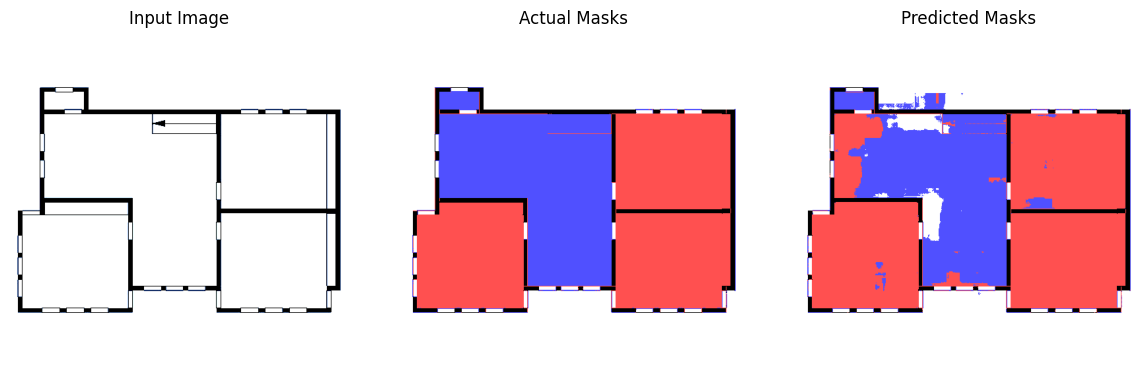

In [35]:
# Model-1

plot_segmentation(
    model=model1, 
    dataset=test_dataset, 
    color_mapping=color_mapping, 
    save_fig=True, 
    #save_root_dir='../generated_examples/', 
    save_root_dir = hyperparameters['output_dir']['results'],
    save_filename='model1_seg_fig', 
    save_format='png', 
    close_img=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


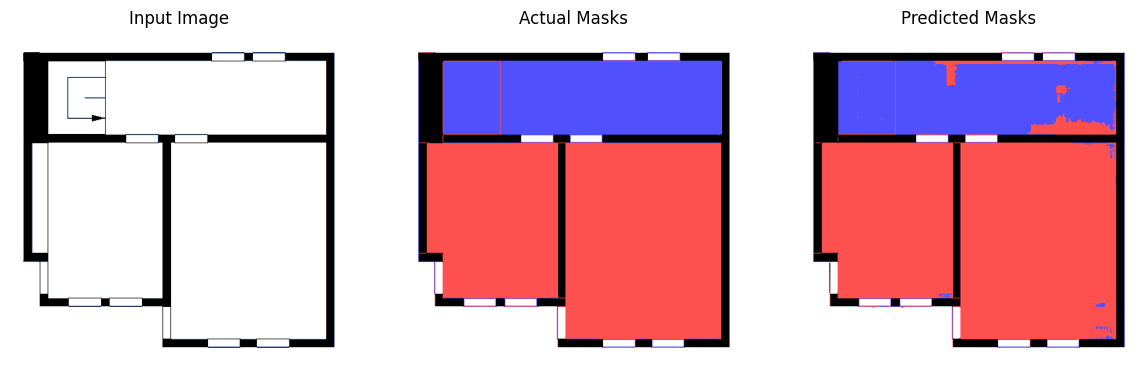

In [36]:
# Model-2

plot_segmentation(
    model=model2, 
    dataset=test_dataset, 
    color_mapping=color_mapping, 
    save_fig=True, 
    #save_root_dir='../generated_examples/', 
    save_root_dir = hyperparameters['output_dir']['results'],
    save_filename='model2_seg_fig', 
    save_format='png', 
    close_img=False
)

## Save Predictions

In [37]:
# Model1 Saving
save_pred_masks(
    model=model1,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model1'],
    input_folder='./images/test',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

save_pred_masks(
    model=model1,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model1'],
    input_folder='./images/train',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

In [38]:
# Model2 Saving
save_pred_masks(
    model=model2,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model2'],
    input_folder='./images/test',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

save_pred_masks(
    model=model2,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model2'],
    input_folder='./images/train',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

## History Graphs

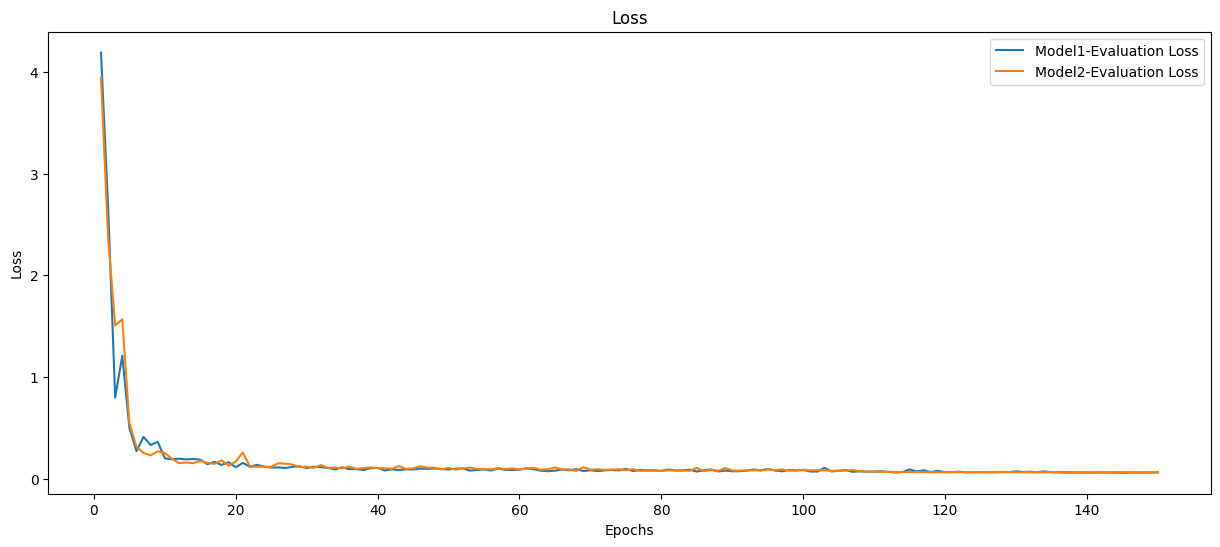

In [39]:
epoch_range = np.arange(1, hyperparameters['epochs']+1, 1, dtype=int)

plt.figure(figsize = (15,6))
plt.title(f"Loss")
plt.plot(epoch_range, history['model1']['eval_loss'], label="Model1-Evaluation Loss")
plt.plot(epoch_range, history['model2']['eval_loss'], label="Model2-Evaluation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
loss_dir = os.path.join(hyperparameters['output_dir']['results'], 'loss_graph.png')
plt.savefig(loss_dir, format='png', bbox_inches='tight')

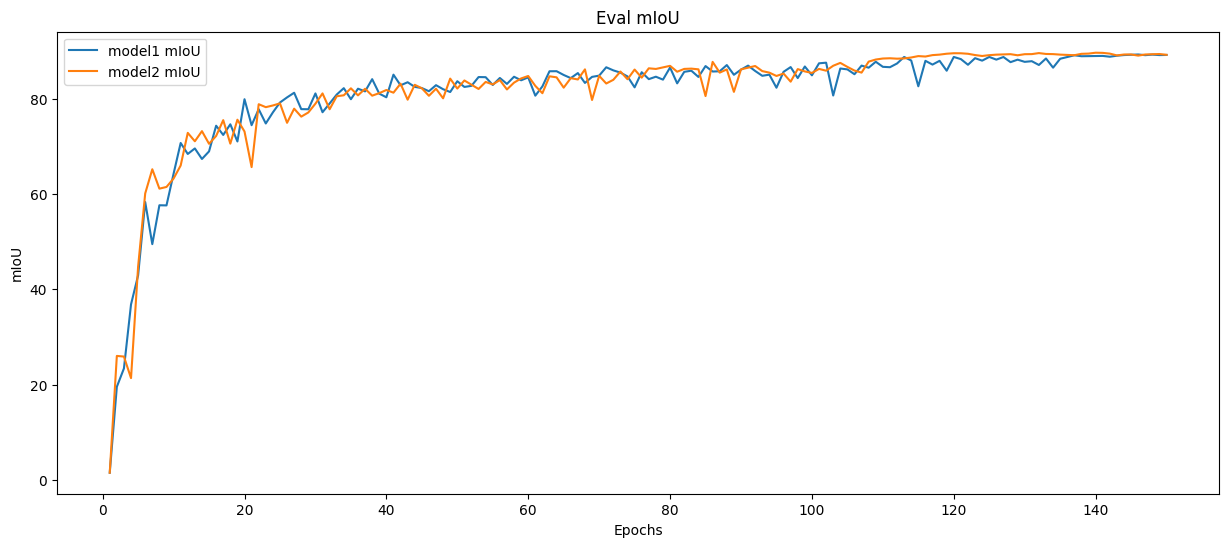

In [40]:
plt.figure(figsize = (15,6))
plt.title(f"Eval mIoU")
plt.plot(epoch_range, history['model1']['eval_miou'], label="model1 mIoU")
plt.plot(epoch_range, history['model2']['eval_miou'], label="model2 mIoU")
plt.xlabel("Epochs")
plt.ylabel("mIoU")
plt.legend();
miou_dir = os.path.join(hyperparameters['output_dir']['results'], 'miou_graph.png')
plt.savefig(miou_dir, format='png', bbox_inches='tight')

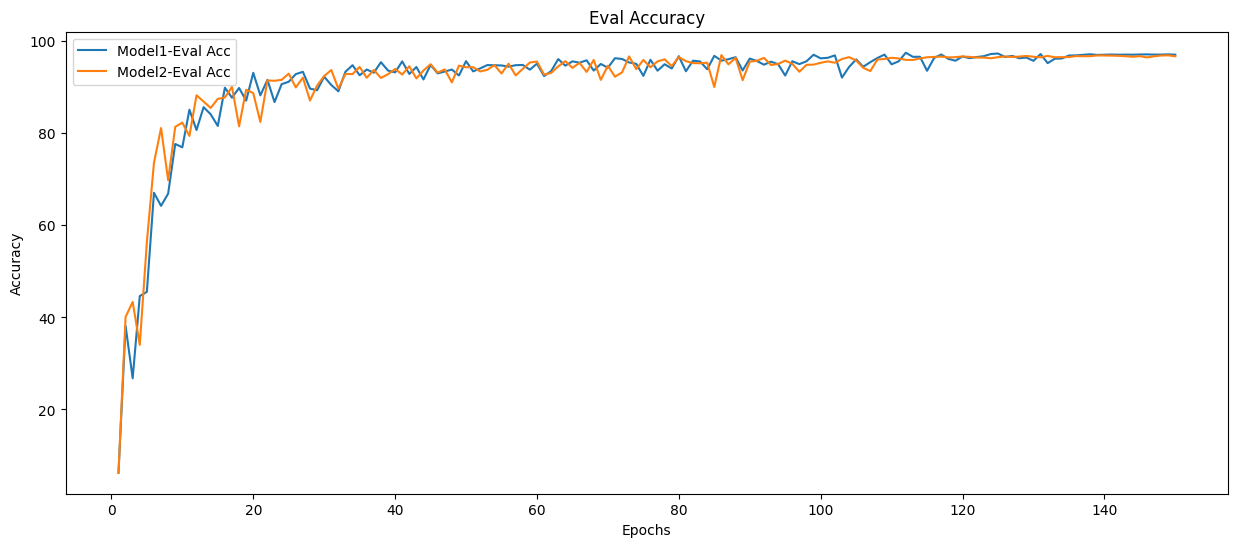

In [41]:
acc_tensor1 = torch.tensor(history['model1']['eval_acc'])
acc_tensor1 = acc_tensor1.to('cpu')
acc_list1 = acc_tensor1.tolist()

acc_tensor2 = torch.tensor(history['model2']['eval_acc'])
acc_tensor2 = acc_tensor2.to('cpu')
acc_list2 = acc_tensor2.tolist()

plt.figure(figsize = (15,6))
plt.title(f"Eval Accuracy")
plt.plot(epoch_range, acc_list1, label="Model1-Eval Acc")
plt.plot(epoch_range, acc_list2, label="Model2-Eval Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
acc_dir = os.path.join(hyperparameters['output_dir']['results'], 'accuracy_graph.png')
plt.savefig(acc_dir, format='png', bbox_inches='tight')